# Predict People Flow by using RNN

In [186]:
import numpy as np
import torch

In [187]:
import matplotlib.pyplot as plt
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

## Data Preparation

In [188]:
import pandas as pd

path = '../data/num_file/p003.csv'
p003 = pd.read_csv(path)

Merge "date" and "hour" columns to be datetime

In [189]:
p003['datetime'] = pd.to_datetime(p003['date'])+pd.to_timedelta(p003['hour'], unit='h')
p003 = p003.drop(['date', 'hour'], axis=1)
p003.set_index('datetime', inplace=True)
p003.columns=['y']
p003['y'] = p003['y'].astype(float)
print(p003)

                           y
datetime                    
2022-05-26 14:00:00   2680.0
2022-05-26 18:00:00  25768.0
2022-05-26 19:00:00  29898.0
2022-05-26 20:00:00  29425.0
2022-05-26 21:00:00  27602.0
...                      ...
2022-06-30 23:00:00  12735.0
2022-07-01 00:00:00   3457.0
2022-07-01 01:00:00   2616.0
2022-07-01 02:00:00   2296.0
2022-07-01 03:00:00   1531.0

[695 rows x 1 columns]


Resample the data that are not existed

In [190]:
p003 = p003.resample('H').mean()
p003.index.freq = 'H'
print(p003)

                           y
datetime                    
2022-05-26 14:00:00   2680.0
2022-05-26 15:00:00      NaN
2022-05-26 16:00:00      NaN
2022-05-26 17:00:00      NaN
2022-05-26 18:00:00  25768.0
...                      ...
2022-06-30 23:00:00  12735.0
2022-07-01 00:00:00   3457.0
2022-07-01 01:00:00   2616.0
2022-07-01 02:00:00   2296.0
2022-07-01 03:00:00   1531.0

[854 rows x 1 columns]


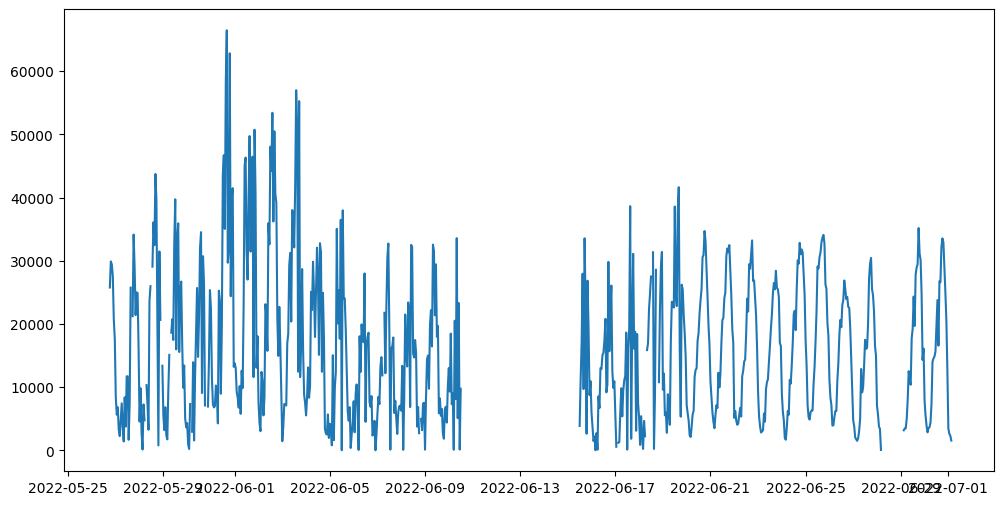

In [191]:
plt.plot(p003['y'])

# Transform the data

### Windowing

In [192]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [193]:
p003_cp = p003.copy()
handle_missing_data(p003_cp)

found 159 missing observations...


/var/folders/7l/hpz3ccrd3_zdd3c0rbn38bnh0000gn/T/ipykernel_17257/3588771845.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.isna().sum())


In [194]:
p003_df = one_step_forecast(p003_cp, 5)
print(p003_df.shape)

(849, 6)


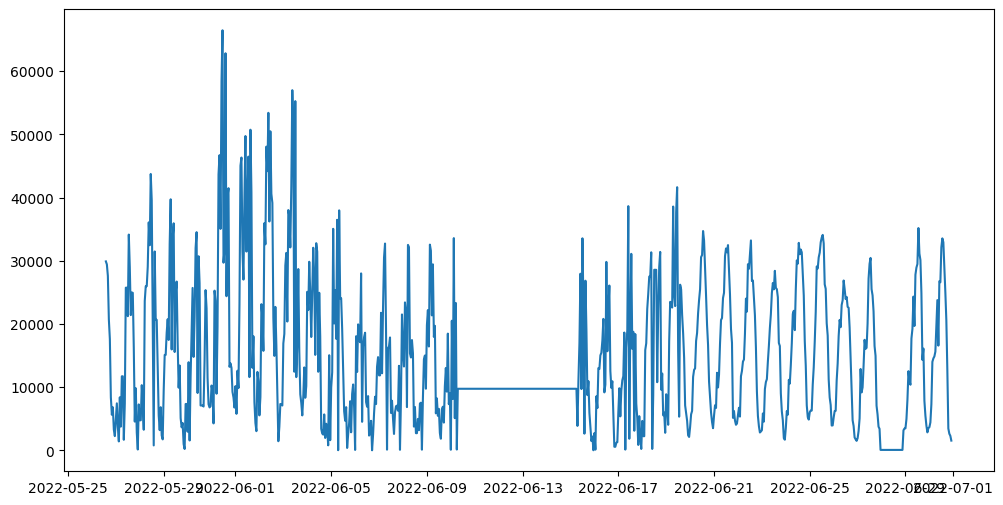

In [195]:
plt.plot(p003_df['y'])

### Scale and split data

In [196]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [197]:
scale_p003 = Standardize(p003_df)
train_p003, test_p003, val_p003 = scale_p003.fit_transform()

In [198]:
print(f'''
train: {len(train_p003)}, test: {len(test_p003)}, val: {len(val_p003)}
      ''')


train: 689, test: 84, val: 76
      


### Split into X and Y (Features and Target)

Create the features_target_pt func to return a PyTorch Tensor object

In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [200]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [201]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

Split the train, validate, and test sets into x and y

In [202]:
(y_train, y_val, y_test, x_train, x_val, x_test) = features_target_pt(train_p003, val_p003, test_p003)

Check type and len

In [203]:
type(x_test)

torch.Tensor

In [204]:
y_train.shape

torch.Size([689, 1])

In [205]:
x_train.shape

torch.Size([689, 5, 1])

## RNN Model

The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [206]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [207]:
issubclass(RNN, nn.Module)

True

Create the train_model_pt func

In [208]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    # Define Loss Function
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    # Extract the training, testing and validation sets
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    # Define a history object to keep track of the train and val loss
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In the preceding code, we are looping through each epoch, initializing the hidden state ($W_{hh}$). On each iteration, we will evaluate on the validation set and store both results from training and validation

### Training and Testing

In [209]:
params = {
    'input_size': x_train.shape[1],
    'output_size': 1,
    'units': 32,
    'n_layers': 1,
    'epochs': 1000,
    'print_every': 50,
    'lr': 0.01,
    'train_data': (x_train, y_train),
    'val_data': (x_val, y_val),
    'test_data': (x_test, y_test),
    'idx': test_p003.index,
    'scale': scale_p003
}

0/1000 - Loss:  0.9411094188690186, val_loss: 0.505756139755249


50/1000 - Loss:  0.3994975686073303, val_loss: 0.07805649191141129
100/1000 - Loss:  0.3209448754787445, val_loss: 0.08735384792089462
150/1000 - Loss:  0.3090915083885193, val_loss: 0.08355893939733505
200/1000 - Loss:  0.2362963855266571, val_loss: 0.09808216243982315
250/1000 - Loss:  0.1689959317445755, val_loss: 0.17614060640335083
300/1000 - Loss:  0.22450046241283417, val_loss: 0.12477869540452957
350/1000 - Loss:  0.14860348403453827, val_loss: 0.2045331448316574
400/1000 - Loss:  0.10461360216140747, val_loss: 0.21540766954421997
450/1000 - Loss:  0.10322590917348862, val_loss: 0.2894209027290344
500/1000 - Loss:  0.0780230462551117, val_loss: 0.2711752951145172
550/1000 - Loss:  0.11247196793556213, val_loss: 0.2146540731191635
600/1000 - Loss:  0.07900916039943695, val_loss: 0.22953836619853973
650/1000 - Loss:  0.07235397398471832, val_loss: 0.2497439831495285
700/1000 - Loss:  0.06933627277612686, val_loss: 0.2376077026128769
750/1000 - Loss:  0.069322869181633, val_loss: 

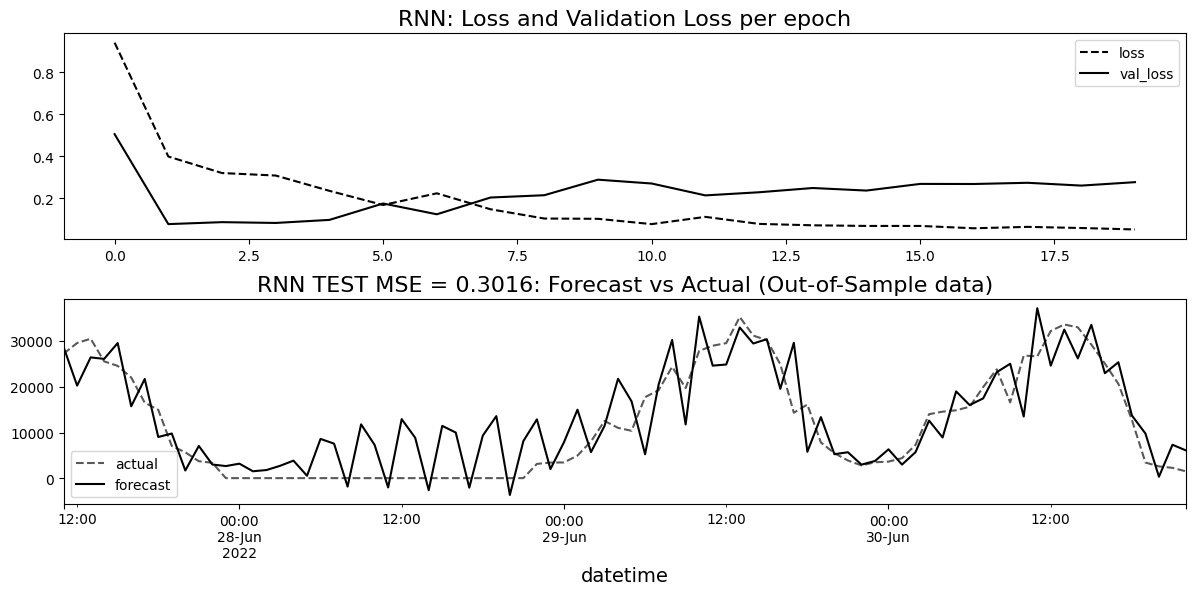

In [210]:
p003_rnn, history_rnn = train_model_pt('RNN', **params)

## LSTM Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [211]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/1000 - Loss:  0.9867382645606995, val_loss: 0.6750641465187073
50/1000 - Loss:  0.37837767601013184, val_loss: 0.12656399607658386
100/1000 - Loss:  0.27821820974349976, val_loss: 0.3531476855278015
150/1000 - Loss:  0.2340914011001587, val_loss: 0.4705977141857147
200/1000 - Loss:  0.16615359485149384, val_loss: 0.7093856930732727
250/1000 - Loss:  0.1492740660905838, val_loss: 0.5653576850891113
300/1000 - Loss:  0.1263650506734848, val_loss: 0.604986846446991
350/1000 - Loss:  0.10023755580186844, val_loss: 0.6965646147727966
400/1000 - Loss:  0.10242744535207748, val_loss: 0.530083954334259
450/1000 - Loss:  0.07783444970846176, val_loss: 0.6620040535926819
500/1000 - Loss:  0.07180231064558029, val_loss: 0.6497066617012024
550/1000 - Loss:  0.0554068461060524, val_loss: 0.6395336985588074
600/1000 - Loss:  0.06069300323724747, val_loss: 0.6644262671470642
650/1000 - Loss:  0.05234735086560249, val_loss: 0.6342174410820007
700/1000 - Loss:  0.05048343166708946, val_loss: 0.641749

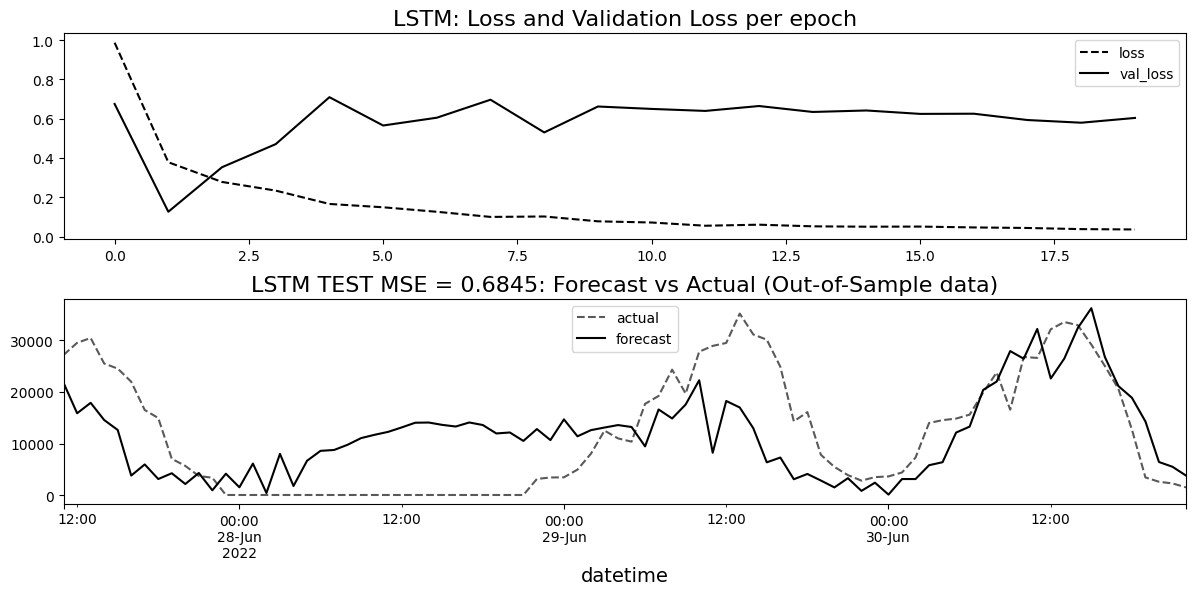

In [212]:
p003_lstm, history_lstm = train_model_pt('LSTM', **params)

In [213]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

/Users/phongwitsrikokcharoen/miniconda3/envs/flow/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0/1000 - Loss:  1.0081347227096558, val_loss: 0.6664733290672302
50/1000 - Loss:  0.3913004696369171, val_loss: 0.1573358029127121
100/1000 - Loss:  0.2928415536880493, val_loss: 0.36719366908073425
150/1000 - Loss:  0.2634631395339966, val_loss: 0.4248788356781006
200/1000 - Loss:  0.2111862301826477, val_loss: 0.5038537979125977
250/1000 - Loss:  0.28016766905784607, val_loss: 0.14143475890159607
300/1000 - Loss:  0.2271384745836258, val_loss: 0.28355059027671814
350/1000 - Loss:  0.19128216803073883, val_loss: 0.4587469696998596
400/1000 - Loss:  0.16708612442016602, val_loss: 0.6261461973190308
450/1000 - Loss:  0.14353586733341217, val_loss: 0.6097120046615601
500/1000 - Loss:  0.13808737695217133, val_loss: 0.6222977042198181
550/1000 - Loss:  0.10473611950874329, val_loss: 0.6432676315307617
600/1000 - Loss:  0.09377641975879669, val_loss: 0.6284181475639343
650/1000 - Loss:  0.0853087306022644, val_loss: 0.6278669238090515
700/1000 - Loss:  0.08788473159074783, val_loss: 0.6204

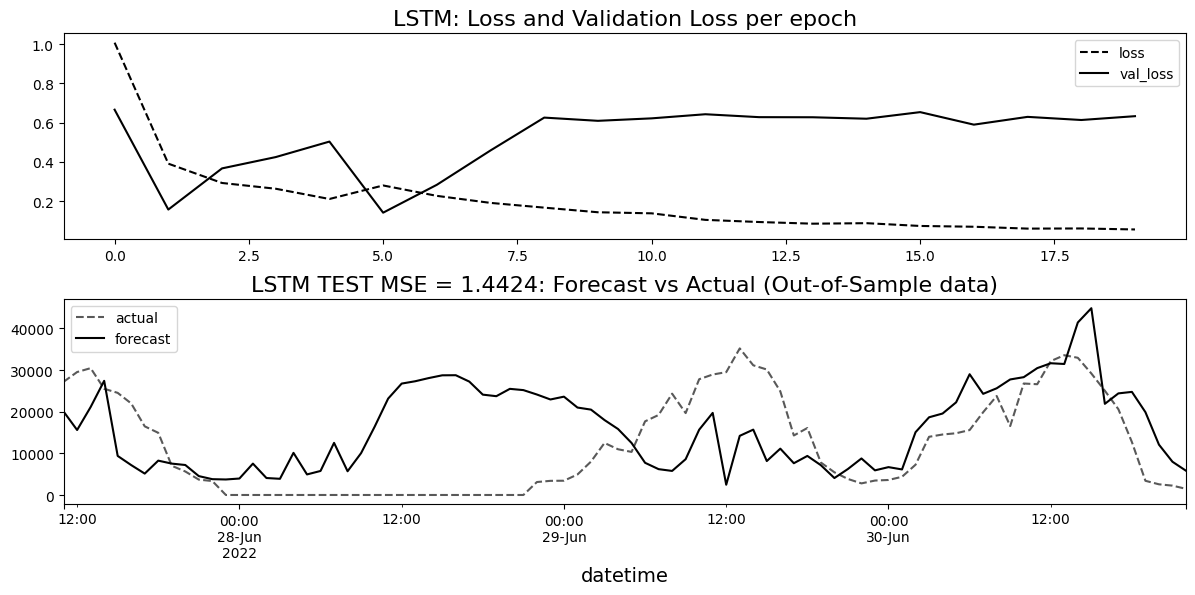

In [214]:
p003_lstm_d, history_lstm_d = train_model_pt('LSTM', **params)

## GRU Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [215]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

/Users/phongwitsrikokcharoen/miniconda3/envs/flow/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0/1000 - Loss:  1.0437461137771606, val_loss: 0.7272289395332336
50/1000 - Loss:  0.3775450587272644, val_loss: 0.12188280373811722
100/1000 - Loss:  0.29935067892074585, val_loss: 0.2787742018699646
150/1000 - Loss:  0.23273347318172455, val_loss: 0.40529146790504456
200/1000 - Loss:  0.17790819704532623, val_loss: 0.7152460217475891
250/1000 - Loss:  0.15816755592823029, val_loss: 0.8123172521591187
300/1000 - Loss:  0.13431991636753082, val_loss: 0.8172421455383301
350/1000 - Loss:  0.11482088267803192, val_loss: 0.9408614635467529
400/1000 - Loss:  0.10428323596715927, val_loss: 1.1060882806777954
450/1000 - Loss:  0.08893655240535736, val_loss: 1.14572274684906
500/1000 - Loss:  0.08058622479438782, val_loss: 1.0869746208190918
550/1000 - Loss:  0.07764491438865662, val_loss: 0.9474313855171204
600/1000 - Loss:  0.0694977417588234, val_loss: 0.8704532980918884
650/1000 - Loss:  0.06308342516422272, val_loss: 0.7276085615158081
700/1000 - Loss:  0.05175422504544258, val_loss: 0.576

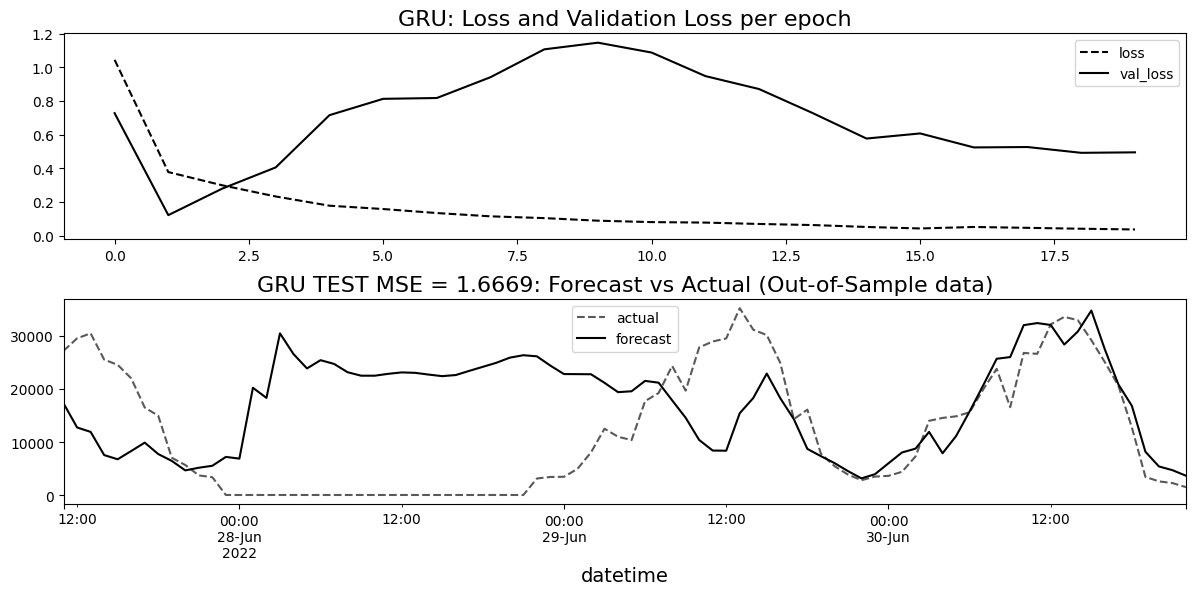

In [216]:
p003_gru, history_gru = train_model_pt('GRU', **params)